# Target-Reaching Study

# Check which Python

In [1]:
# Check which kernel 
import sys 

# Check python version 
print(sys.version)
# Check which executable 
print()
print(sys.executable)
# And what is in the path
print()
print(sys.path) 

3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:09:02) [GCC 11.2.0]

/opt/anaconda3/envs/langevin/bin/python3.13

['/opt/anaconda3/envs/langevin/lib/python313.zip', '/opt/anaconda3/envs/langevin/lib/python3.13', '/opt/anaconda3/envs/langevin/lib/python3.13/lib-dynload', '', '/opt/anaconda3/envs/langevin/lib/python3.13/site-packages']


In [2]:
# sys.path.insert(0, '/path/to/other/env/lib/python3.9/site-packages')

# Importations

In [1]:
import numpy as np

import sys
import time
from tqdm import tqdm
import copy
from scipy.io import savemat

from scipy.optimize import curve_fit

from multiprocessing import Pool

from numba import njit

In [2]:
from simulations.langevin.DoubleWalls_Overdamped_Langevin import DoubleWallsLangevin

In [3]:
import simulations.langevin.ComputeObservables as co

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpltools import annotation
from matplotlib import rc
import seaborn as sns
# custom_params = {
#     "xtick.direction": "in",
#     "ytick.direction": "in",
#     "lines.markeredgecolor": "k",
#     "lines.markeredgewidth": 0.3,
#     "lines.linewidth": 1.5, 
#     "xtick.direction": "in",
#     "xtick.labelsize": 9,
#     "ytick.direction": "in",
#     "ytick.labelsize": 9, 
#     "font.size": 9, 
#     "font.family": "serif",
#     "figure.dpi": 500,
#     "text.usetex": True,
# }
# sns.set_theme(context = "notebook", style="ticks", rc=custom_params)
rc('lines', linewidth=1.5, markeredgecolor='k', markeredgewidth=0.3)
rc('xtick', direction='in', labelsize=9)
rc('ytick', direction='in', labelsize=9)
rc('font', family='serif', size=9)
rc('text', usetex=True)
rc('figure', dpi=500)
rc('savefig', dpi=500)

BlueUB = (0, 157/255, 224/255)
BrownUB = (68/255, 58/255, 49/255)

# Auxiliary Functions 

In [5]:
def compute_lB(a, drho, kT=4e-21, g=9.81):
    return kT / (4/3*np.pi*a**3*drho*g)

In [6]:
# Here z is the gap between the particle and the (bottom) wall

def diffusing_diffusivity_z(z, a):
    res = (6*(z**2) + 2*a*z) / (6*(z**2) + 9*a*z + 2*(a**2))
    return res

def diffusing_diffusivity_x(z, a):
    ksi = a / (a + z)
    res = (1 - (9/16)*(ksi) + (1/8)*(ksi**3) - (45/256)*(ksi**4) + (1/16)*(ksi**5))
    return res

In [7]:
def _P_eq(z, B, lD, lB):
    return np.exp(-B * np.exp(-z / lD) - z / lB)

def P_eq(z, B, lD, lB, normalize=True):
    if type(z) == float:
        if z < 0:
            res = 0
        return _P_eq(z, B, lD, lB)
    res = _P_eq(z, B, lD, lB)
    res[z < 0] = 0
    if normalize:
        res = res / np.trapezoid(res, z) # Ok because it is a change of variable
    return res

In [8]:
def Levy(t, L, D, x0=0):
    res = abs(L - x0) / np.sqrt(4*np.pi*D*t**3) * np.exp(-(L - x0)**2 / (4*D*t)) 
    return res

In [9]:
def logarithmic_hist(data, begin, stop, num=50, base=2, density=True):
    if begin == 0:
        beg = stop / num
        bins = np.logspace(
            np.log(beg) / np.log(base), 
            np.log(stop) / np.log(base), 
            num - 1, 
            base=base, 
        )
        widths = bins[1:] - bins[:-1]
        bins = np.cumsum(widths[::-1])
        bins = np.concatenate(([0], bins))
        widths = bins[1:] - bins[:-1]
    else:
        bins = np.logspace(
            np.log(begin) / np.log(base), 
            np.log(stop) / np.log(base), 
            num, 
            base=base, 
            dtype=np.float64, 
        )
        widths = bins[1:] - bins[:-1]
    hist, bins = np.histogram(data, bins=bins, density=density)
    # hist = hist / np.trapezoid(hist, bins)
    # normalize by bin width
    bins_center = (bins[1:] + bins[:-1]) / 2
    return bins_center, widths, hist

# Global variables

In [10]:
kb = 1.38e-23
T = 293
kT = kb * T
print(kT)

4.0434e-21


In [11]:
# Parameters

H = 100e-6

a = 1.48e-6

H -= a # to be checked again

rho_m = 1000
rho_p = 1050
drho = rho_p - rho_m

lB = compute_lB(a = a, drho = drho)
print('Boltzmann length = {} nm'.format(lB * 1e9))

lD = 20e-9
B = 4.5
print("B = {}".format(B))
print('Debye length = {} nm'.format(lD * 1e9))

eta0 = 0.001

dt = 0.01
Nt = 300_000

Boltzmann length = 600.5473074094804 nm
B = 4.5
Debye length = 20.0 nm


# One trajectory

## Simulation of the trajectory

In [14]:
%%time

# Simulation 
# tc_0 = time.time() 
brown = DoubleWallsLangevin(
    dt=dt, Nt=Nt, Nt_sub=1, 
    a=a, H=H, lD=lD, lB=lB, B=B, eta0=eta0, T=T, 
    R0=None, #(0,-H + a + lB),
)
brown.trajectory() #Compute trajectory of "brown"
# print("Compute time = ", time.time()-tc_0)

CPU times: user 3.14 s, sys: 17 μs, total: 3.14 s
Wall time: 3.14 s


In [15]:
x = brown.Xn
z = brown.Zn + H
tps = np.arange(len(z)) * dt

In [16]:
save = {}

save['x'] = np.copy(x)
save['z'] = np.copy(z)

save['a'] = a
save['H'] = H
save['B'] = B
save['lD'] = lD
save['lB'] = lB
save['rho_m'] = rho_m
save['rho_p'] = rho_p
save['drho'] = drho
save['eta0'] = eta0

save['Nt'] = Nt 
save['dt'] = dt

## Look at the trajectory and observables

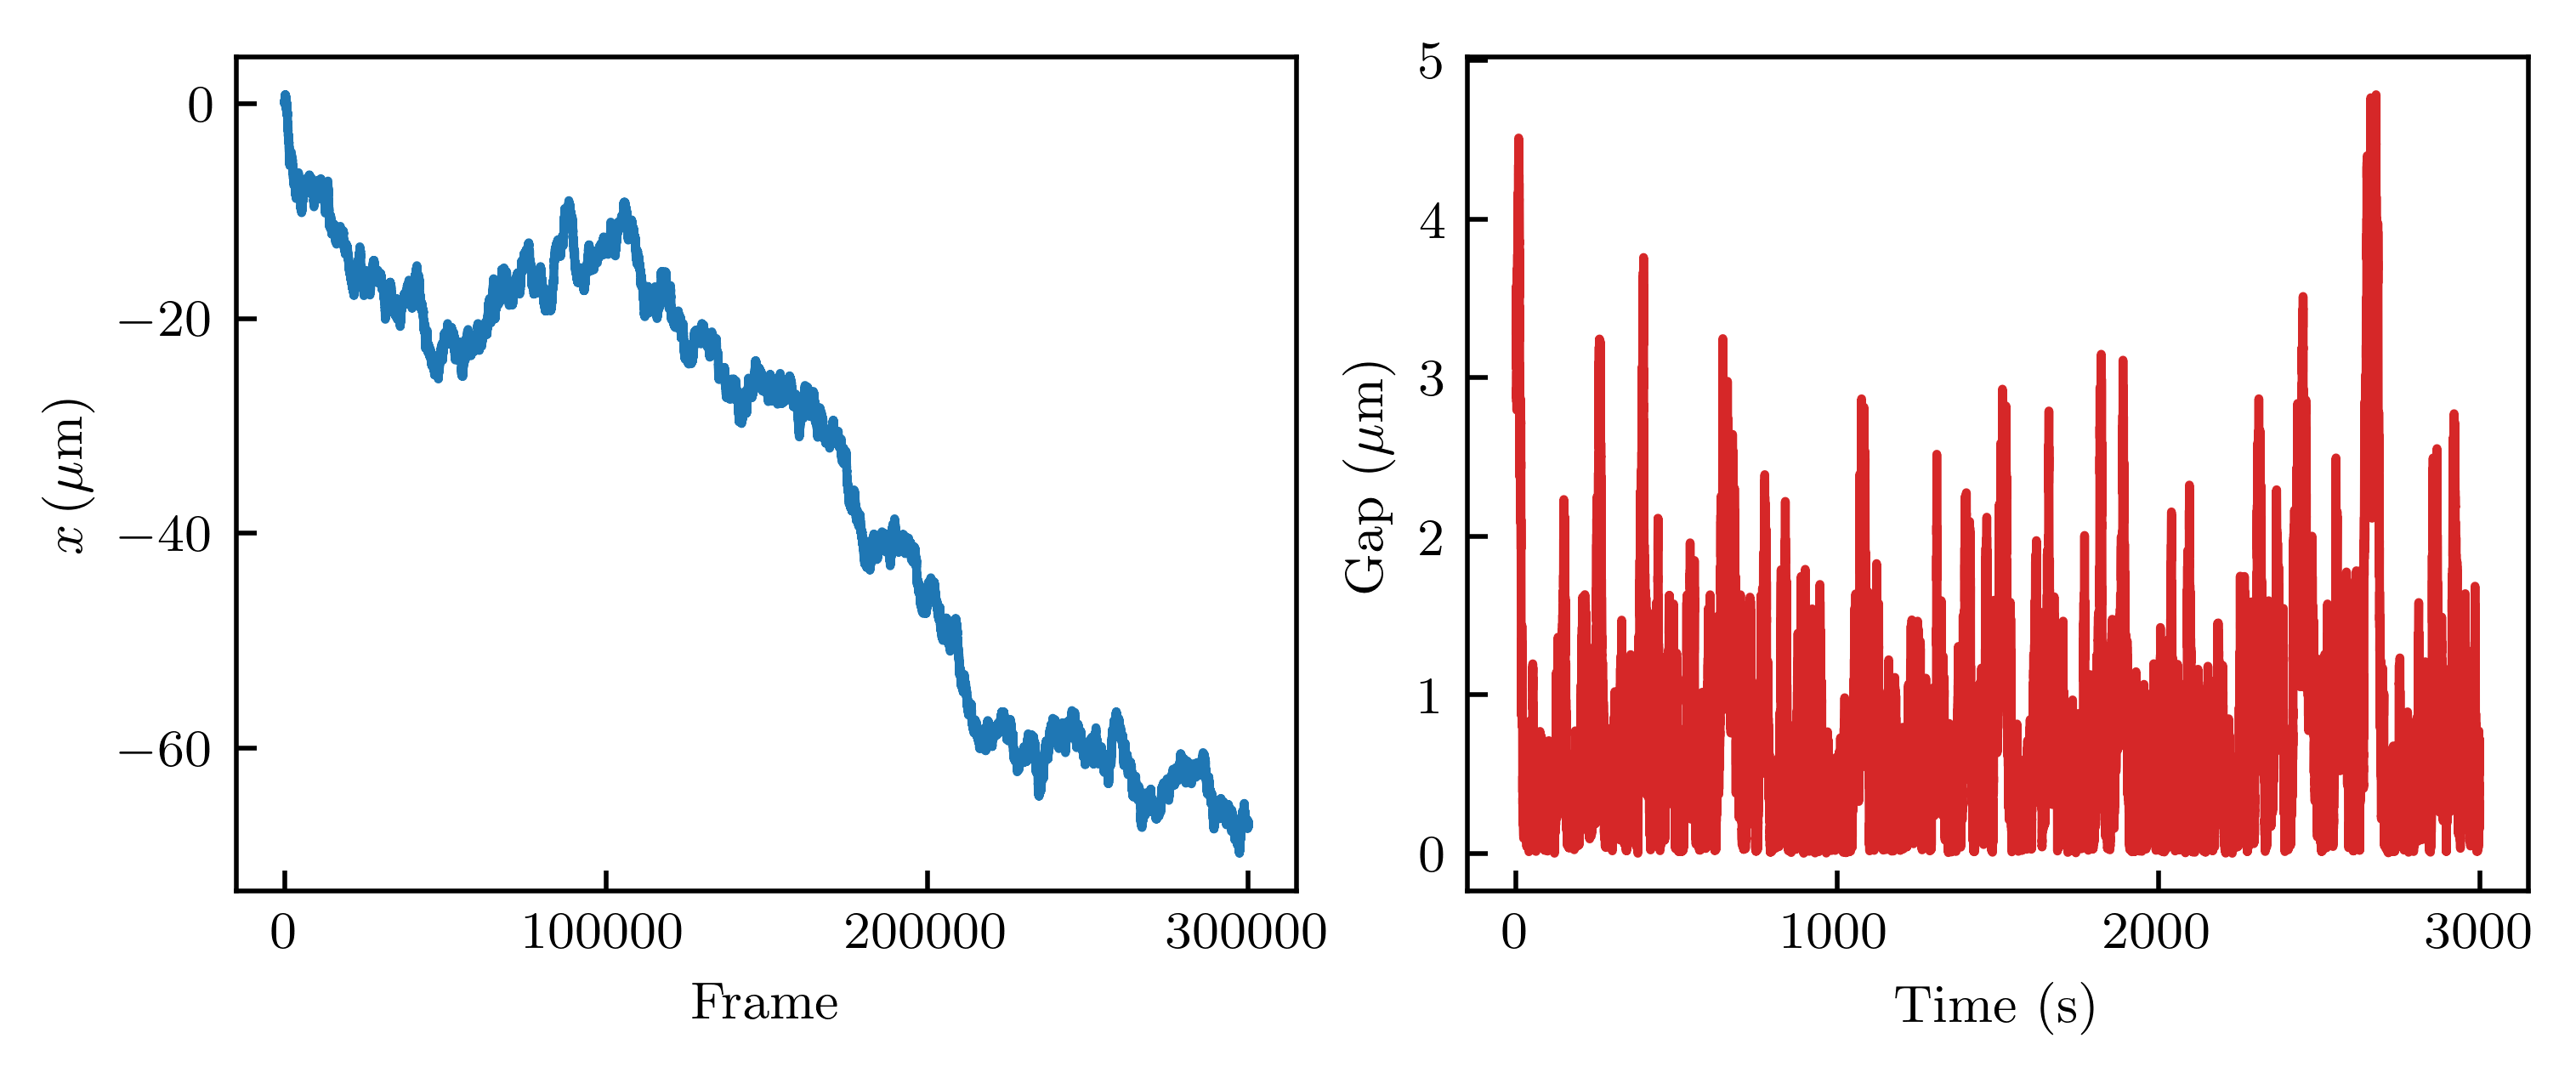

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15/2.54, 6/2.54))

axes[0].plot(x*1e6, color = 'tab:blue')
axes[0].set(xlabel='Frame', ylabel=r'$x \, (\mathrm{\mu m})$')
axes[1].plot(tps, z*1e6, color = 'tab:red')
axes[1].set(xlabel='Time (s)', ylabel=r'Gap $(\mathrm{\mu m})$')

plt.tight_layout(pad=0.1)
plt.show()
# fig.savefig('traj.pdf')

In [18]:
# fig.savefig('traj.pdf')

In [19]:
# Compute MSDs

delta_frame_nb = np.concatenate(
    (
        np.arange(1, 10, 1),
        np.arange(10, 100, 10),
        np.arange(100, 1000, 100),
        np.arange(1000, 70000, 1000),
    )
)

delta_time_MSD = tps[delta_frame_nb]

MSD_x, std_MSD_x = co.moment(2, x, delta_frame_nb, return_std = True, retrieve_mean = True) # Function in wrapper
MSD_z, std_MSD_z = co.moment(2, z, delta_frame_nb, return_std = True, retrieve_mean = True)

D0 = kT / (6*np.pi*eta0*a)

start = 0
stop = 10
coef_MSD_x = np.polyfit(delta_time_MSD[start:stop], MSD_x[start:stop], 1)
coef_MSD_z = np.polyfit(delta_time_MSD[start:stop], MSD_z[start:stop], 1)
meanDx_MSD = coef_MSD_x[0] / 2
meanDz_MSD = coef_MSD_z[0] / 2

In [20]:
save['delta_time_MSD'] = np.copy(delta_time_MSD)
save['MSD_x'] = np.copy(MSD_x)
save['MSD_z'] = np.copy(MSD_x)

In [21]:
zz = np.linspace(1e-9, 10e-6, int(1e6))
meanDx = np.trapezoid(P_eq(zz, B, lD, lB) * diffusing_diffusivity_x(zz, a), zz) * D0
meanDz = np.trapezoid(P_eq(zz, B, lD, lB) * diffusing_diffusivity_z(zz, a), zz) * D0

def _P_dz_long(dz, B, lD, lB, zz=zz):
    return np.trapezoid(P_eq(zz, B, lD, lB, normalize=False) * P_eq(zz + dz, B, lD, lB, normalize=False), zz)
def P_dz_long(dzz, B, lD, lB, zz=zz):
    res = np.zeros_like(dzz)
    for i in range(len(res)):
        res[i] = _P_dz_long(dzz[i], B, lD, lB, zz=zz)
    res = res / np.trapezoid(res, dzz)
    return res
dzz = np.linspace(-10e-6, 10e-6, int(1e3))
plateau_MSDz = np.trapezoid(dzz ** 2 * P_dz_long(dzz, B, lD, lB), dzz)

In [22]:
meanDx

np.float64(8.612523039624089e-14)

In [23]:
meanDx_MSD

np.float64(8.341649366299285e-14)

In [24]:
# Compute Peq

# The error on the PDF and the equilibrium force is estimated by:
# Adding a nanometric noise to the trajectory, several times.

n_noisy = 100 # Number of iterations of the noise-adding procedure
min_distance = 50e-9 
max_distance = 1e-6
n_bins = 30

data_P_eq, data_F_eq = co.PeqFeq(z, n_noisy, min_distance, max_distance, n_bins)
# PeqFeq returns two dictionnaries, containing data corresponding to Peq and Feq

x_P_eq, width_P_eq, y_P_eq, std_y_P_eq, err_y_P_eq = data_P_eq.values()
x_F_eq, width_F_eq, y_F_eq, std_y_F_eq, err_y_F_eq = data_F_eq.values()

del data_P_eq, data_F_eq

In [25]:
save['x_P_eq'] = np.copy(x_P_eq)
save['y_P_eq'] = np.copy(y_P_eq)
save['x_F_eq'] = np.copy(x_F_eq)
save['y_F_eq'] = np.copy(y_F_eq)

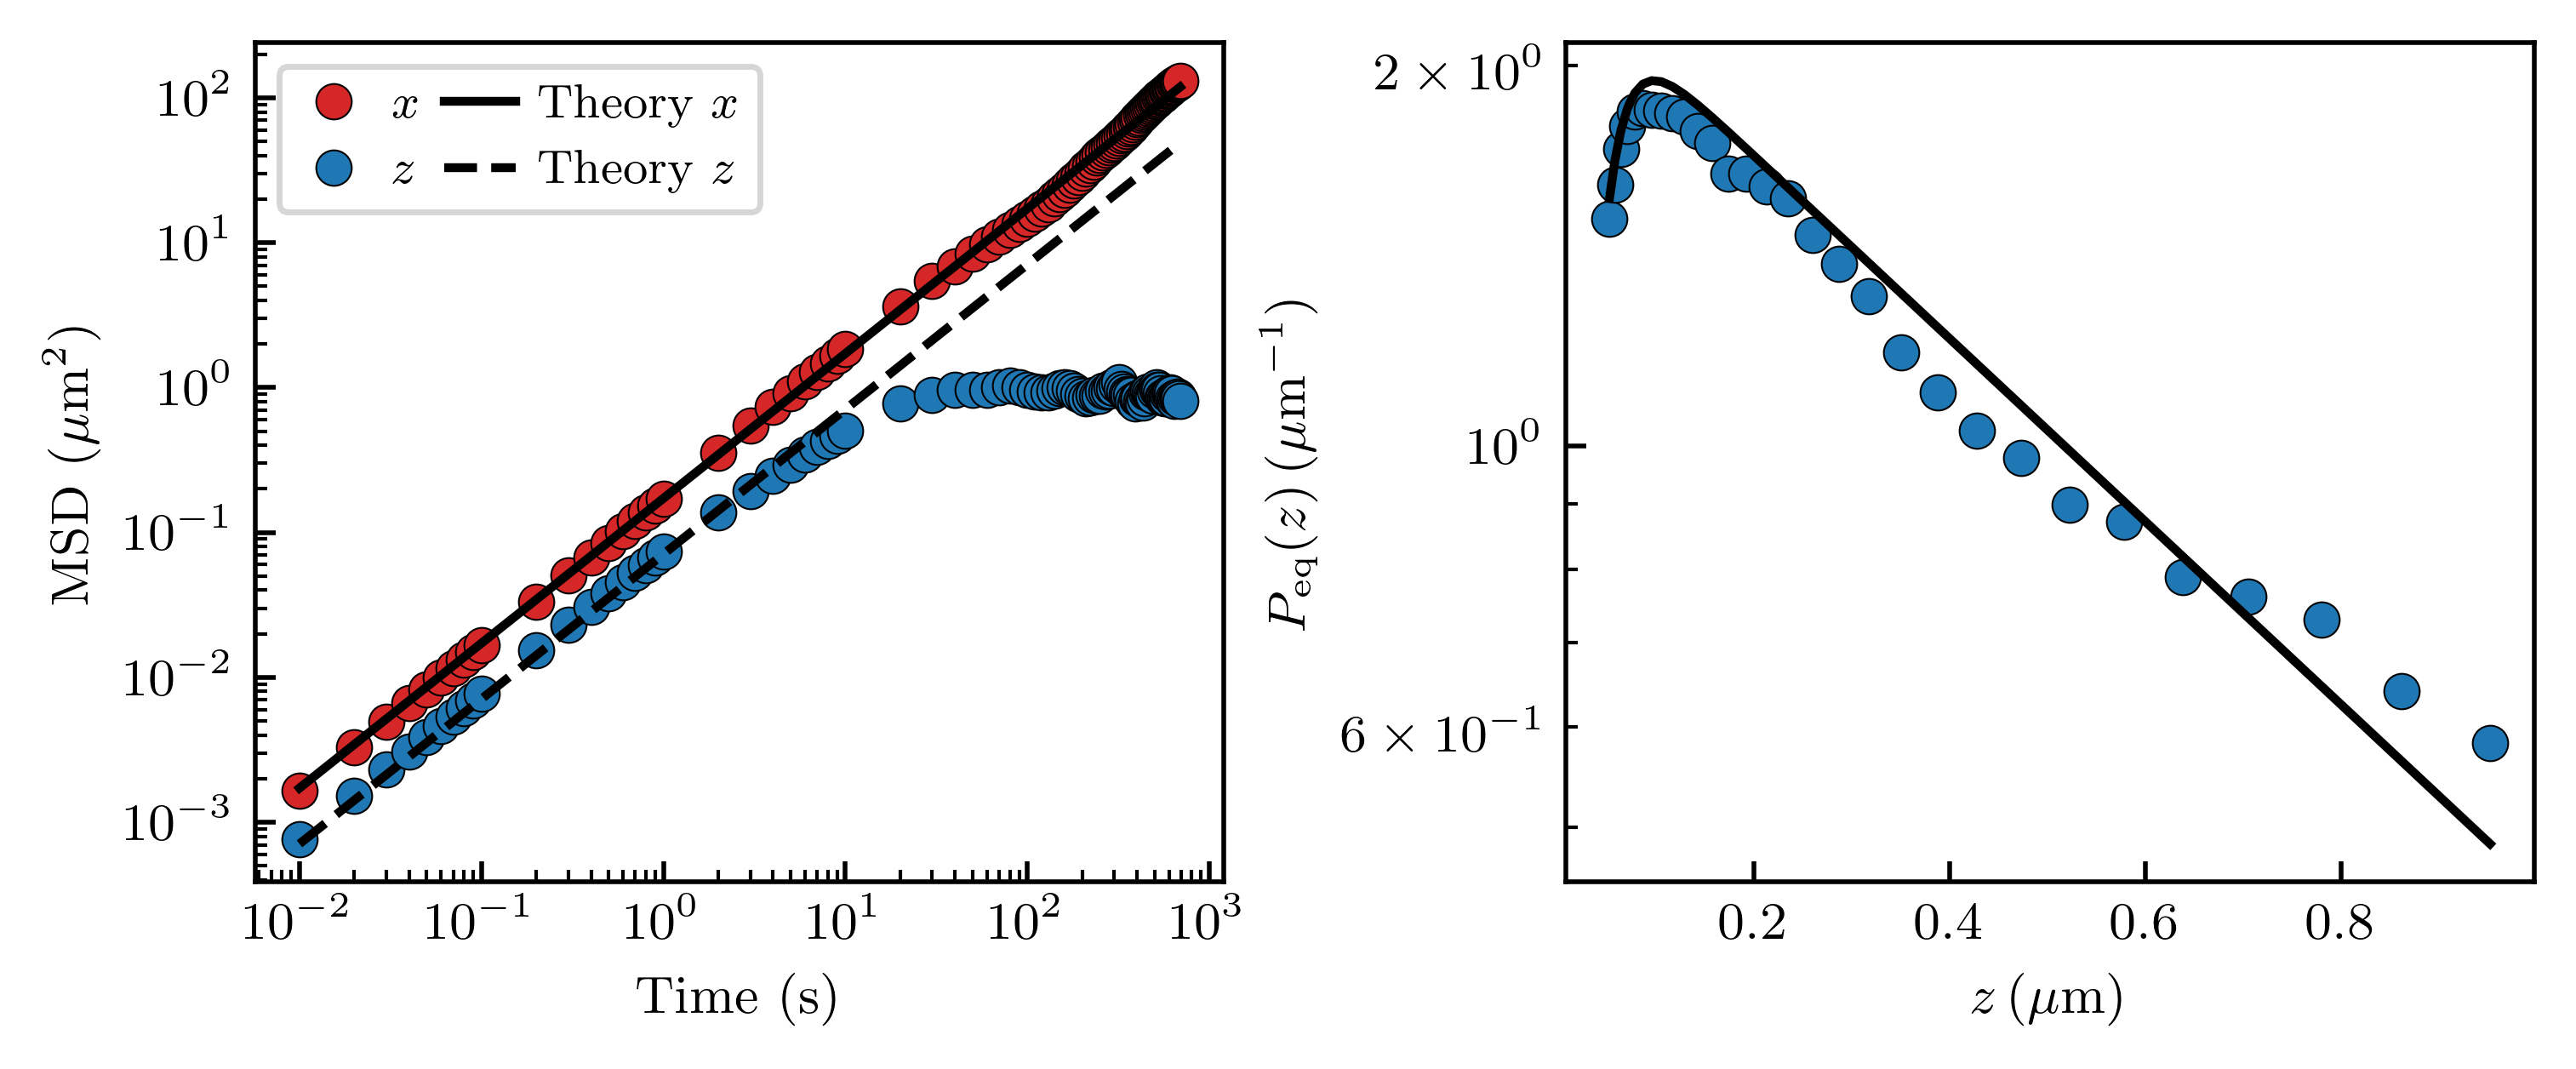

In [26]:
# Plot 

fig, axes = plt.subplots(1, 2, figsize=(15/2.54, 6/2.54))

axes[0].plot(delta_time_MSD, MSD_x*1e12, 'o', mfc='tab:red', label=r'$x$')
axes[0].plot(delta_time_MSD, MSD_z*1e12, 'o', mfc='tab:blue', label=r'$z$')
axes[0].plot(delta_time_MSD, 2 * meanDx * delta_time_MSD * 1e12, ls='-', c='k', label=r'Theory $x$')
axes[0].plot(delta_time_MSD, 2 * meanDz * delta_time_MSD * 1e12, ls='--', c='k', label=r'Theory $z$')
axes[0].legend(frameon=True, handletextpad=0.5, handlelength=1.5, ncol=2, columnspacing=0.5, prop={'size': 8})
axes[0].set(xlabel='Time (s)', ylabel=r'MSD $(\mathrm{\mu m ^2})$', xscale='log', yscale='log')
axes[1].plot(x_P_eq*1e6, y_P_eq*1e-6, 'o', mfc='tab:blue')
axes[1].plot(x_P_eq*1e6, P_eq(x_P_eq, B, lD, lB, normalize=True)*1e-6, ls='-', c='k')
axes[1].set(xlabel=r'$z \, \mathrm{(\mu m)}$', ylabel=r'$P_\mathrm{eq}(z) \, \mathrm{(\mu m ^{-1})}$', xscale='linear', yscale='log')

plt.tight_layout(pad=0.2)
plt.show()

In [30]:
# fig.savefig('first_observables.pdf')

## First-Passage Time

In [27]:
L = 300e-9

In [28]:
# Compute FPTs: naive

def get_FPT_naive(x, dt, L=500e-9):
    Ntot = len(x)
    res = []
    for i in tqdm(range(Ntot)):
        x0 = x[i]
        j = i
        c = 0
        while x[j] < x0 + L:
            j += 1
            c += 1
            if j >= Ntot:
                break
        if j < Ntot:
            res.append(c)
    res = np.array(res)
    res = res * dt
    return res 

In [33]:
%%time 

FPT_x = get_FPT_naive(x, dt=dt, L=L)

100%|██████████████████████████████████████████████████████████| 300000/300000 [01:07<00:00, 4424.31it/s]

CPU times: user 1min 7s, sys: 53.1 ms, total: 1min 7s
Wall time: 1min 7s


In [29]:
# Compute FPTs: Parallel

# traj = np.copy(x)
# Ntot = len(traj)
# frames = np.arange(Ntot)

def _get_FPT_parallel(traj, Ntot, i, l):
    """
    Returns the time to reach x0+l, starting from one position x0.
    The position x0 corresponds to x[i], with i a time step of the trajectory. 
    """
    x0 = traj[i]
    j = i
    c = 0
    while traj[j] < x0 + l:
        j += 1
        c += 1
        if j >= Ntot:
            break
    if j >= Ntot:
        return np.nan
    res = c * dt 
    return res

def get_FPT_parallel(n_proc, traj, l):
    """
    Returns the distributions of FPTs, for one distance L. 
    Computed over n_proc CPUs.
    """
    Ntot = len(traj)
    frames = np.arange(Ntot)
    with Pool(n_proc) as p:
        res = p.starmap(_get_FPT_parallel, [(traj, Ntot, ff, l) for ff in frames])
    res = np.array(res)
    res = res[~np.isnan(res)]
    return res

# map can be replaced by starmap for more convenient definition of functions to parallelize. 

In [30]:
%%time 

FPT_x = get_FPT_parallel(20, x, L)

Process ForkPoolWorker-17:
Process ForkPoolWorker-20:
Process ForkPoolWorker-18:
Process ForkPoolWorker-15:
Process ForkPoolWorker-13:
Process ForkPoolWorker-19:
Process ForkPoolWorker-14:
Process ForkPoolWorker-16:
Process ForkPoolWorker-5:
Process ForkPoolWorker-9:
Process ForkPoolWorker-8:
Process ForkPoolWorker-11:
Process ForkPoolWorker-4:
Process ForkPoolWorker-12:
Process ForkPoolWorker-1:
Process ForkPoolWorker-6:
Process ForkPoolWorker-3:
Process ForkPoolWorker-10:
Process ForkPoolWorker-2:
Process ForkPoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (mos

KeyboardInterrupt: 

In [ ]:
# Compute FPTs: Numba

@njit
def get_FPT_numba(x, dt, L=500e-9):
    Ntot = len(x)
    res = []
    for i in range(Ntot):
        x0 = x[i]
        j = i
        c = 0
        while x[j] < x0 + L:
            j += 1
            c += 1
            if j >= Ntot:
                break
        if j < Ntot:
            res.append(c)
    res = np.array(res)
    res = res * dt
    return res 

In [ ]:
%%time

FPT_x = get_FPT_numba(x, dt=dt, L=L)

In [ ]:
bins_FPT_x, _, hist_FPT_x = co.logarithmic_hist(FPT_x, begin=np.min(FPT_x), stop=np.max(FPT_x), num=30, base=10)

In [ ]:
bins_FPT_x_theory = np.logspace(-2, np.log10(3e1), 1000)
hist_FPT_x_theory = Levy(bins_FPT_x_theory, L=300e-9, D=meanDx_MSD)
# hist_FPT_x_theory = Levy(bins_FPT_x_theory, )

In [ ]:
popt, _ = curve_fit(lambda t, D: Levy(t, L=L, D=D), bins_FPT_x, hist_FPT_x, p0=[meanDx])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15/2.54, 7/2.54))
ax.loglog(bins_FPT_x, hist_FPT_x, 'o')
ax.plot(bins_FPT_x_theory, hist_FPT_x_theory, '--k')
ax.plot(bins_FPT_x_theory, Levy(bins_FPT_x_theory, L=L, D=popt[0]), '-k')
ax.plot(bins_FPT_x_theory, Levy(bins_FPT_x_theory, L=300e-9, D=meanDx), '--', c='tab:red')
ax.set(xlabel=r'$\tau \, \mathrm{(s)}$', ylabel=r'$P(\tau) \, \mathrm{(s^{-1})}$')
ax.annotate(
    r"L = {} $\mu$m".format(np.round(L * 1e6, 1)), 
    xy=(0, 0),  xycoords='axes fraction', xytext=(0.7, 0.2), textcoords='axes fraction', color='k',  
    horizontalalignment='right', verticalalignment='top', 
    fontsize=9, 
)
plt.tight_layout()
plt.show()

In [40]:
# fig.savefig('P_tau.pdf')

# Several Trajectories

## Generate several trajectories

In [12]:
N_traj = 100_000
Nt = 2
dt = 1e-4
Nt_sub = 1

print(B, lD, lB)

4.5 2e-08 6.005473074094804e-07


In [13]:
def compute_one_traj(i, dt, Nt, Nt_sub, a, H, lD, lB, B, eta0, T, R0=None):
    brown = DoubleWallsLangevin(
        dt=dt, Nt=Nt, Nt_sub=Nt_sub, 
        a=a, H=H, lD=lD, lB=lB, B=B, eta0=eta0, T=T, 
        R0=R0, 
    )
    brown.trajectory()
    x = brown.Xn
    z = brown.Zn + H
    return x, z

In [17]:
%%time 

params = [(i, dt, Nt, Nt_sub, a, H, lD, lB, B, eta0, T, None) for i in np.arange(N_traj)]
with Pool(20) as p:
    res = p.starmap(compute_one_traj, params)

CPU times: user 429 ms, sys: 155 ms, total: 584 ms
Wall time: 2min 13s


In [18]:
xs = np.zeros((Nt, N_traj))
zs = np.zeros((Nt, N_traj))
for j in range(N_traj):
    xs[:,j] = res[j][0]
    zs[:,j] = res[j][1]

In [19]:
save['N_traj'] = N_traj
save['Nt'] = Nt
save['dt'] = dt

save['xs'] = np.copy(xs)
save['zs'] = np.copy(zs)

NameError: name 'save' is not defined

In [20]:
dt = dt * Nt_sub

## Look at trajectories and observables

In [21]:
def measure_Peq(zs, min_distance, max_distance, n_bins, base=2):
    N_traj = zs.shape[1]
    all_x_P_eq, all_width_P_eq, all_y_P_eq = np.zeros((N_traj, n_bins)), np.zeros((N_traj, n_bins)), np.zeros((N_traj, n_bins))
    # Histogram over all the positions z
    for p in range(N_traj):
        z_temp = zs[:,p]
        z_temp = z_temp[~np.isnan(z_temp)]
        x_P_eq_temp, width_P_eq_temp, y_P_eq_temp = logarithmic_hist(zs[:,p], min_distance, max_distance, num=n_bins+1, base=base, density=True)
        all_x_P_eq[p,:] = np.copy(x_P_eq_temp)
        all_width_P_eq[p,:] = np.copy(width_P_eq_temp)
        all_y_P_eq[p,:] = np.copy(y_P_eq_temp)
    x_P_eq = np.nanmean(all_x_P_eq, axis=0)
    width_P_eq = np.nanmean(all_width_P_eq, axis=0)
    y_P_eq = np.nanmean(all_y_P_eq, axis=0)
    del all_x_P_eq, all_width_P_eq, all_y_P_eq
    return x_P_eq, width_P_eq, y_P_eq

In [24]:
%%time 
x_P_eq, width_P_eq, y_P_eq = measure_Peq(zs[:,:], min_distance, max_distance, n_bins, base=10)

# y_P_eq = y_P_eq / np.trapezoid(y_P_eq, x_P_eq)

/opt/anaconda3/envs/langevin/lib/python3.13/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


CPU times: user 2.36 s, sys: 77.7 ms, total: 2.44 s
Wall time: 2.39 s


In [25]:
delta_frame_nb = np.concatenate(
    (
        np.arange(1, 10, 1),
        np.arange(10, 100, 10),
        np.arange(100, 1000, 100),
        np.arange(1000, 10000, 1000),
        np.arange(10000, 50000, 10000), 
    )
)

delta_time_MSD = delta_frame_nb * dt

In [26]:
from math import sqrt

def moment(n, xs, delta_frame_nb, return_err=False, retrieve_mean=False):
    res = np.zeros_like(delta_frame_nb) * np.nan
    err = np.zeros_like(res) * np.nan
    N_traj = np.shape(xs)[1]
    for i, df in enumerate(delta_frame_nb):
        dxs = xs[df:,:] - xs[:-df,:]
        if retrieve_mean:
            for p in range(N_traj):
                dxs[:,p] = dxs[:,p] - np.nanmean(dxs[:,p])
        dxs_n = dxs ** n 
        res[i] = np.nanmean(dxs_n)
        err[i] = np.nanstd(dxs_n) / sqrt(dxs_n.size)
    if return_err:
        return res, err
    return res

def measure_MSD(xs, delta_frame_nb, return_err=False, retrieve_mean=False):
    return moment(2, xs, delta_frame_nb, return_err=return_err, retrieve_mean=retrieve_mean)

# @njit
# def moment_numba(n, xs, delta_frame_nb):
#     res = np.empty_like(delta_frame_nb, dtype=np.float64)
#     err = np.empty_like(res)
#     N_t, N_traj = np.shape(xs)
#     for i in range(len(delta_frame_nb)):
#         df = delta_frame_nb[i]
#         if df <= 0 or df >= N_t:
#             res[i] = np.nan
#             continue
#         count = N_t - df
#         acc = 0.0
#         std = np.empty(N_traj+count, dtype=np.float64)
#         for j in range(N_traj):
#             for k in range(count):
#                 dx_n = (xs[k+df, j] - xs[k, j]) ** n
#                 acc += dx_n
#                 std
#         std = np.array(std)
#         res[i] = acc / (count * N_traj)
#     return res, err

# def measure_MSD_numba(xs, delta_frame_nb):
#     return moment_numba(2, xs, delta_frame_nb)

In [27]:
%%time 

MSD_x, std_MSD_x = measure_MSD(xs, delta_frame_nb, return_err=True)
MSD_z, std_MSD_z = measure_MSD(zs, delta_frame_nb, return_err=True)

CPU times: user 2.5 ms, sys: 1.94 ms, total: 4.45 ms
Wall time: 3.84 ms


/tmp/ipykernel_305059/2691443949.py:13: RuntimeWarning: Mean of empty slice
  res[i] = np.nanmean(dxs_n)
/opt/anaconda3/envs/langevin/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [28]:
D0 = kT / (6*np.pi*eta0*a)

start = 0
stop = 10
coef_MSD_x = np.polyfit(delta_time_MSD[start:stop], MSD_x[start:stop], 1)
coef_MSD_z = np.polyfit(delta_time_MSD[start:stop], MSD_z[start:stop], 1)
meanDx_MSD = coef_MSD_x[0] / 2
meanDz_MSD = coef_MSD_z[0] / 2


Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


LinAlgError: SVD did not converge in Linear Least Squares

In [43]:
zz = np.linspace(1e-9, 10e-6, int(1e6))

meanDx = np.trapezoid(P_eq(zz, B, lD, lB) * diffusing_diffusivity_x(zz, a), zz) * D0
meanDz = np.trapezoid(P_eq(zz, B, lD, lB) * diffusing_diffusivity_z(zz, a), zz) * D0

def _P_dz_long(dz, B, lD, lB, zz=zz):
    return np.trapezoid(P_eq(zz, B, lD, lB, normalize=False) * P_eq(zz + dz, B, lD, lB, normalize=False), zz)
def P_dz_long(dzz, B, lD, lB, zz=zz):
    res = np.zeros_like(dzz)
    for i in range(len(res)):
        res[i] = _P_dz_long(dzz[i], B, lD, lB, zz=zz)
    res = res / np.trapezoid(res, dzz)
    return res
    
dzz = np.linspace(-10e-6, 10e-6, int(1e3))

plateau_MSDz = np.trapezoid(dzz ** 2 * P_dz_long(dzz, B, lD, lB), dzz)

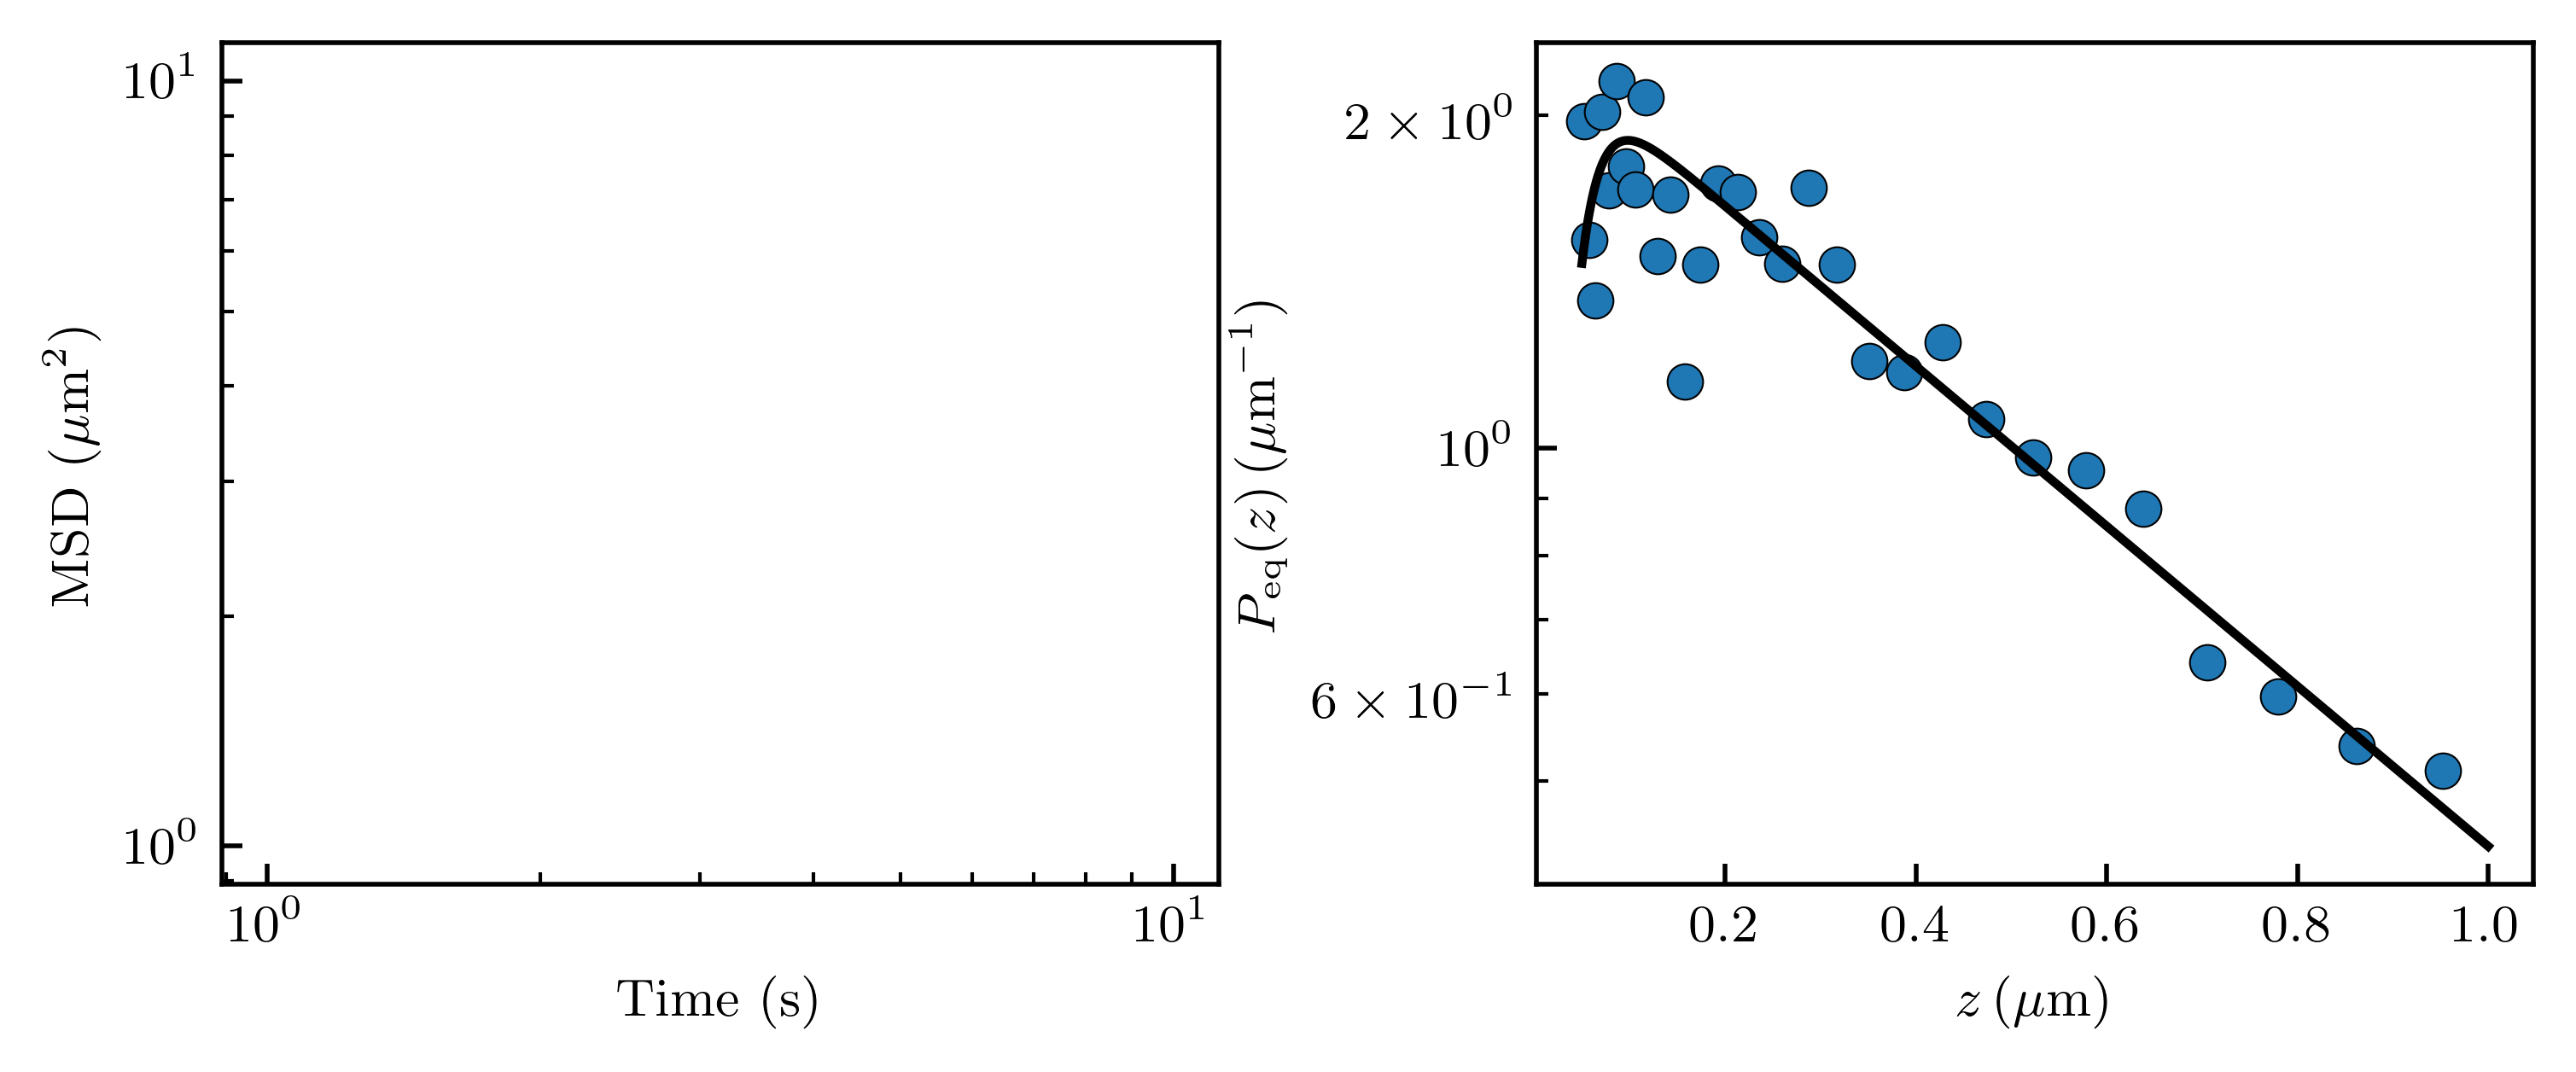

In [30]:
# Plot 

x_P_eq_theory = np.linspace(min_distance, max_distance, int(1e6))
y_P_eq_theory = P_eq(x_P_eq_theory, B, lD, lB, normalize=True)

fig, axes = plt.subplots(1, 2, figsize=(15/2.54, 6/2.54))

# axes[0].plot(delta_time_MSD, MSD_x*1e12, 'o', mfc='tab:red', label=r'$x$')
# axes[0].plot(delta_time_MSD, MSD_z*1e12, 'o', mfc='tab:blue', label=r'$z$')
# axes[0].plot(delta_time_MSD, 2 * meanDx * delta_time_MSD * 1e12, ls='-', c='k', label=r'Theory $x$')
# axes[0].plot(delta_time_MSD, 2 * meanDz * delta_time_MSD * 1e12, ls='--', c='k', label=r'Theory $z$')
# dtime_MSD_long = delta_time_MSD[delta_time_MSD > 0.5]
# axes[0].plot(dtime_MSD_long, np.ones_like(dtime_MSD_long) * plateau_MSDz * 1e12, ls='--', c='k')
# axes[0].legend(frameon=True, handletextpad=0.5, handlelength=1.5, ncol=2, columnspacing=0.5, prop={'size': 8})
axes[0].set(xlabel='Time (s)', ylabel=r'MSD $(\mathrm{\mu m ^2})$', xscale='log', yscale='log')
axes[1].plot(x_P_eq*1e6, y_P_eq*1e-6, 'o', mfc='tab:blue')

# for p in range(N_traj):
#     x_P_eq_temp, width_P_eq_temp, y_P_eq_temp = measure_Peq(zs[:,p:p+1], min_distance, max_distance, n_bins, base=10)
#     axes[1].plot(x_P_eq_temp*1e6, y_P_eq_temp*1e-6, ls='-', c='gray', linewidth=0.3)
    
axes[1].plot(x_P_eq_theory*1e6, y_P_eq_theory*1e-6, ls='-', c='k')
axes[1].set(xlabel=r'$z \, \mathrm{(\mu m)}$', ylabel=r'$P_\mathrm{eq}(z) \, \mathrm{(\mu m ^{-1})}$', xscale='linear', yscale='log')

plt.tight_layout(pad=0.2)
plt.show()

In [ ]:
zs.shape

## First-Passage Times

In [81]:
@njit
def get_FPT_one_particle(x, l):
    Ntot = len(x)
    res = []
    for i in range(Ntot):
        x0 = x[i]
        j = i
        c = 0
        while x[j] < x0 + l:
            j += 1
            c += 1
            if j >= Ntot:
                c = np.nan
                break
        res.append(c)
        # Maybe: add a condition to break the loop if several FPTs in a row are nans
    res = np.array(res)
    res = res * dt
    return res

# @njit
def get_FPT_several_particles(xs, Ls):
    res = []
    N_traj = np.shape(xs)[1]
    for k in range(len(Ls)):
        l = Ls[k]
        fpt_temp = np.zeros_like(xs) * np.nan
        for p in tqdm(range(N_traj)):
            fpt_one_p = get_FPT_one_particle(xs[:,p], l)
            fpt_temp[:len(fpt_one_p),p] = fpt_one_p
        res.append(fpt_temp)
        print("L = {} um done.".format(np.round(l*1e6,2)))
    return res

In [82]:
Ls = [100e-9, 300e-9, 1.5e-6]

In [83]:
%%time

FPT_x = get_FPT_several_particles(xs, Ls)

100%|██████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.22it/s]


L = 0.09999999999999999 um done.


100%|██████████████████████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]


L = 0.3 um done.


100%|██████████████████████████████████████████████████████████████████| 100/100 [08:43<00:00,  5.24s/it]

L = 1.5 um done.
CPU times: user 11min 25s, sys: 2.63 s, total: 11min 27s
Wall time: 11min 22s


In [88]:
save['Ls'] = copy.deepcopy(Ls)
save['FPT_x'] = copy.deepcopy(FPT_x)

In [89]:
k = 1

fpt_x = FPT_x[k][~np.isnan(FPT_x[k])]

print(np.shape(fpt_x))

bins_FPT_x, _, hist_FPT_x = co.logarithmic_hist(fpt_x, begin=np.min(fpt_x), stop=np.max(fpt_x), num=20, base=10, )

bins_FPT_x_theory = np.logspace(np.log10(3e-2), np.log10(5e1), 1000)
hist_FPT_x_theory = Levy(bins_FPT_x_theory, L=fpt.L[k], D=meanDx)

popt, _ = curve_fit(lambda t, D: np.log10(Levy(t, L=fpt.L[k], D=D)), bins_FPT_x, np.log10(hist_FPT_x), p0=[meanDx]) # /!\ log fit
hist_FPT_x_fit = Levy(bins_FPT_x_theory, L=fpt.L[k], D=popt[0])

(29372850,)


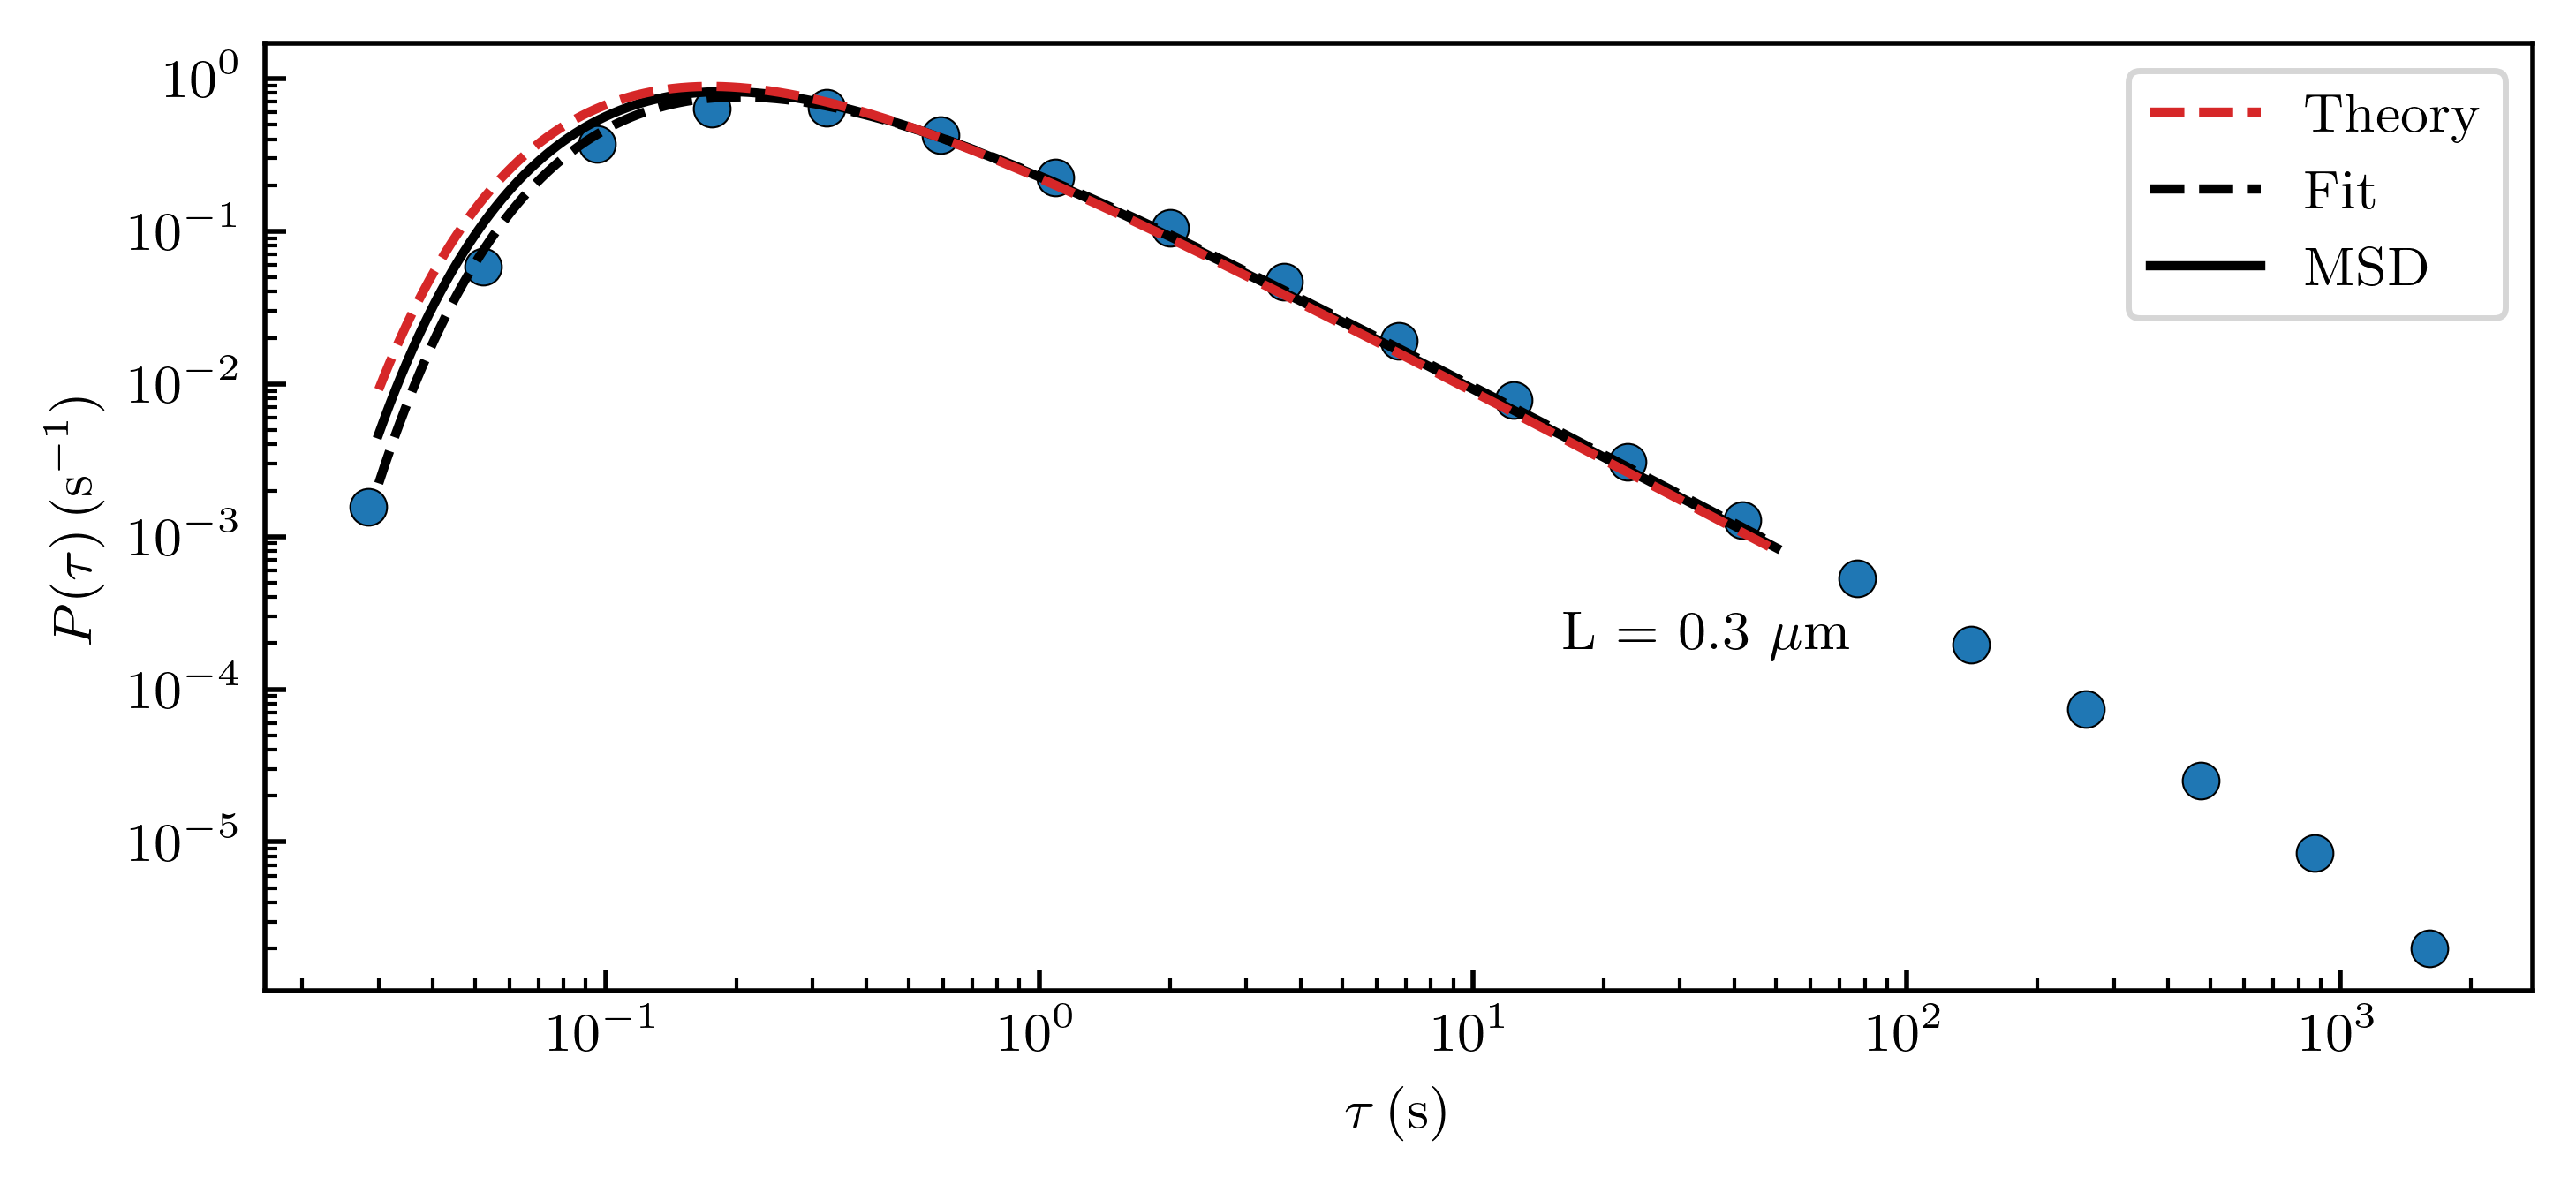

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(15/2.54, 7/2.54))
ax.loglog(bins_FPT_x, hist_FPT_x, 'o')
ax.plot(bins_FPT_x_theory, hist_FPT_x_theory, '--', c='tab:red', label=r'Theory', zorder=3)
ax.plot(bins_FPT_x_theory, hist_FPT_x_fit, '--k', label='Fit')
ax.plot(bins_FPT_x_theory, Levy(bins_FPT_x_theory, L=fpt.L[k], D=meanDx_MSD), '-k', label='MSD')
ax.set(xlabel=r'$\tau \, \mathrm{(s)}$', ylabel=r'$P(\tau) \, \mathrm{(s^{-1})}$')
ax.legend()
ax.annotate(
    r"L = {} $\mu$m".format(np.round(fpt.L[k] * 1e6, 1)), 
    xy=(0, 0),  xycoords='axes fraction', xytext=(0.7, 0.4), textcoords='axes fraction', color='k',  
    horizontalalignment='right', verticalalignment='top', 
    fontsize=9, 
)
plt.tight_layout()
plt.show()

In [96]:
# fig.savefig('FPT_P_tau.pdf')